# Likelihood curves vs parameters in high SNR limit

This notebook is analogous to `02.Likelihood_vs_parameters`, but now we boost the strain to be large with respect to the noise

---

### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import json 
import pandas as pd 
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

### Define some functions 

Now to start, lets make a function that creates some synthetic data for a particular strain, measurement noise and noise seed AND a function that gets a likelihood value given that data 

In [3]:
from system_parameters import SystemParameters
from pulsars import Pulsars
from synthetic_data import SyntheticData
from model import LinearModel
from kalman_filter import KalmanFilter
from priors import priors_dict,bilby_priors_dict
import numpy as np 



#Function to create synthetic data
def create_synthetic_data(h,measurement_noise,seed):

    P    = SystemParameters(h=h,σp=None,σm=measurement_noise,seed=seed)       #define the system parameters as a class
    PTA  = Pulsars(P)               # setup the PTA
    data = SyntheticData(PTA,P)     # generate some synthetic data

    return P,PTA,data

#Fit model to data and return likelihood
def get_likelihood(data,parameter_name,parameter_value,P,PTA,measurement_model):

    _P = copy.copy(P)
    _PTA = copy.copy(PTA)
    _P.measurement_model = measurement_model
    

    #Define the model 
    model = LinearModel(_P)

    #Initialise the Kalman filter
    KF = KalmanFilter(model,data.f_measured,_PTA)

    #Get the
    guessed_parameters = priors_dict(_PTA,_P) #These are the true parameters 
    guessed_parameters[parameter_name] = np.array([parameter_value])

    
    model_likelihood, model_state_predictions_x,model_state_predictions_y = KF.likelihood(guessed_parameters)

    return model_likelihood

### Create some data

In [4]:
h = 1e-6 #A boosted strain value
measurement_noise = 1e-11
seed=1236
P,PTA,data = create_synthetic_data(h,measurement_noise,seed)

INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1236
INFO:root:You are assigning the σp terms randomly
INFO:root:You are including the PSR terms in your synthetic data generation


### Single example: $\Omega$

In [5]:
import copy 
import logging 
logger = logging.getLogger().setLevel(logging.ERROR)


#set the measurement model
measurement_model = 'pulsar' #Set the measurement model 



parameter_name = "omega_gw"
N = 1000
parameter_range = np.logspace(-9,-5,N)
likelihood_curves_earth_omega = np.zeros(len(parameter_range))             


for i,p in enumerate(parameter_range):
    p = parameter_range[i]
    likelihood_curves_earth_omega[i] = get_likelihood(data,parameter_name,p,P,PTA,measurement_model)


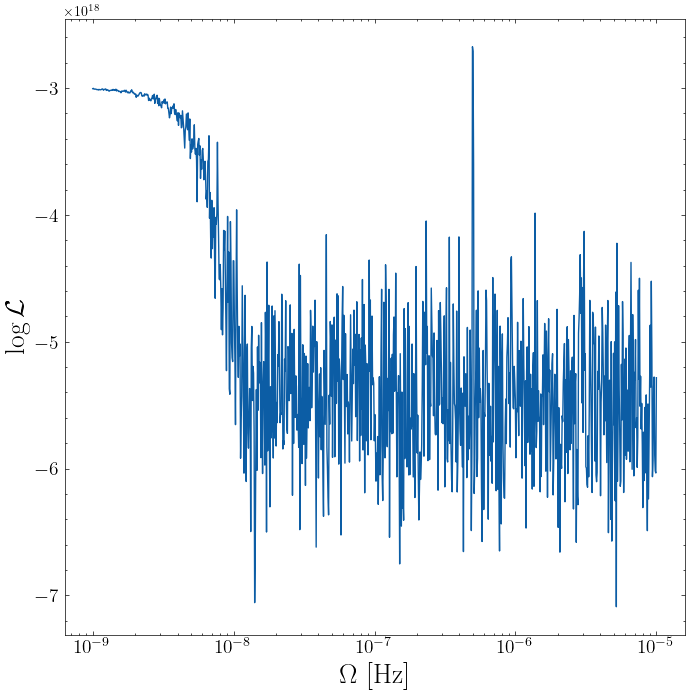

In [6]:
from plotting import plot_likelihood
plot_likelihood(parameter_range,likelihood_curves_earth_omega,r"$\Omega$ [Hz]",log_x_axes=True)

### Now lets do the same again, but iterate over all parameters:

In [7]:
#Set the measurement model again
measurement_model = 'pulsar' #Set the measurement model 


parameter_names = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw", "h"]
N = int(1e3)
parameter_ranges = [np.logspace(-9,-5,N),
                    np.linspace(-1.0,1.0,N),
                    np.linspace(2.0,3.0,N),
                    np.linspace(0.5,1.5,N),
                    np.linspace(0.5,1.5,N),
                    np.linspace(0.5,1.5,N),
                    np.logspace(-13,-11,N)
]



likelihood_data_dictionary={}


for j,parameter_name in enumerate(parameter_names):
    parameter_range = parameter_ranges[j]
    likelihood_data_array = np.zeros(len(parameter_range))     
      

    for i,p in enumerate(parameter_range):
        p = parameter_range[i]
        likelihood_data_array[i] = get_likelihood(data,parameter_name,p,P,PTA,measurement_model)

    likelihood_data_dictionary[parameter_name] = likelihood_data_array

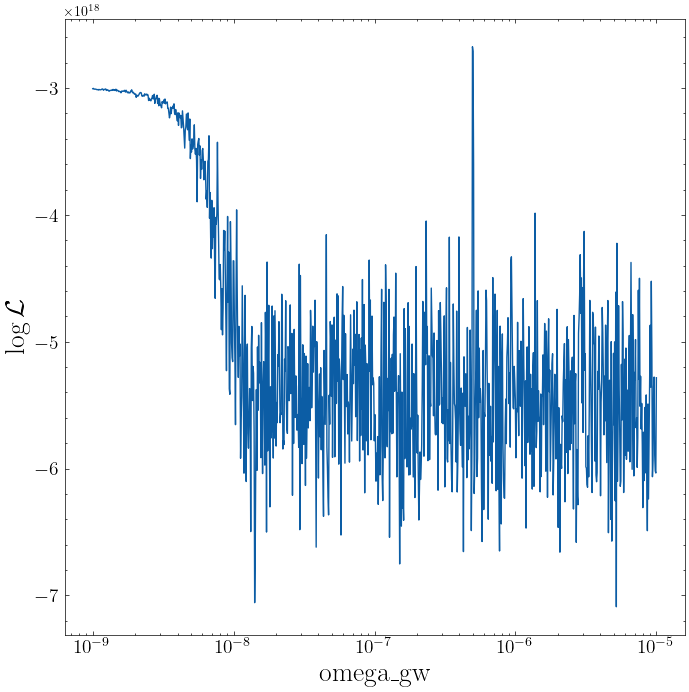

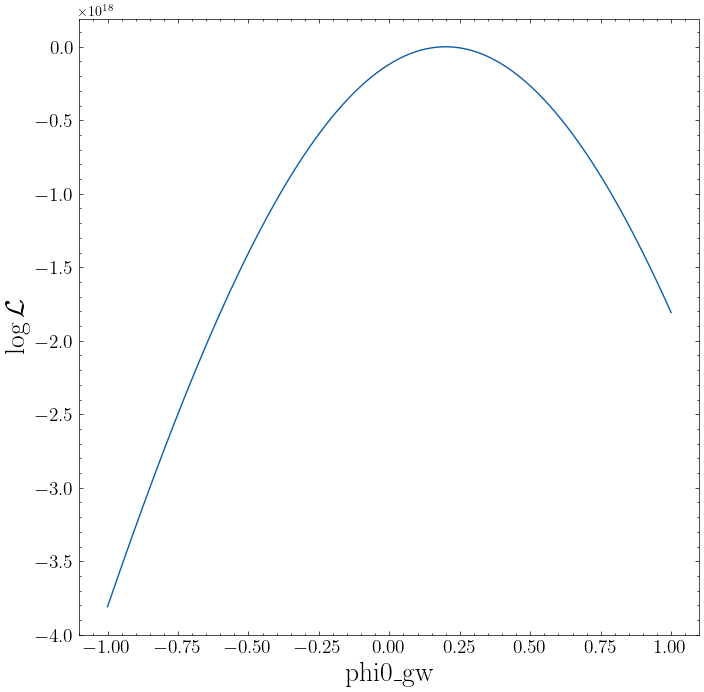

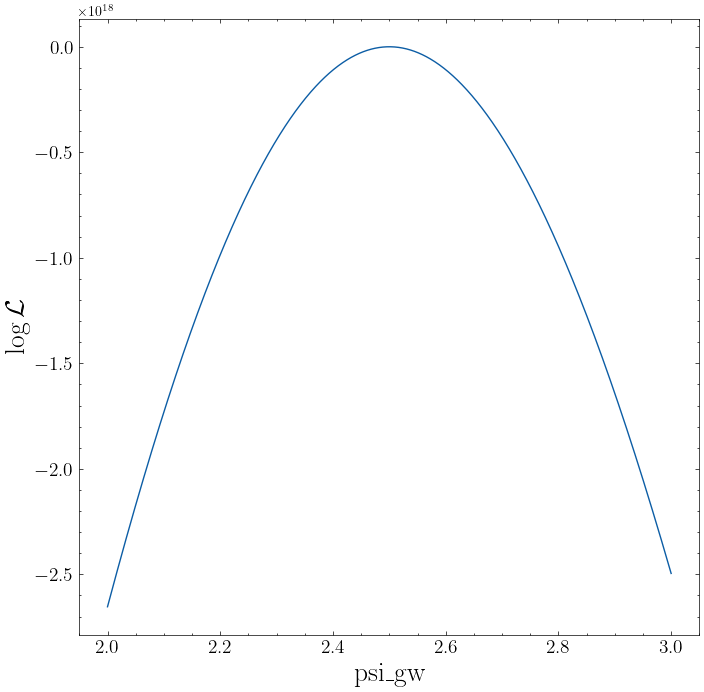

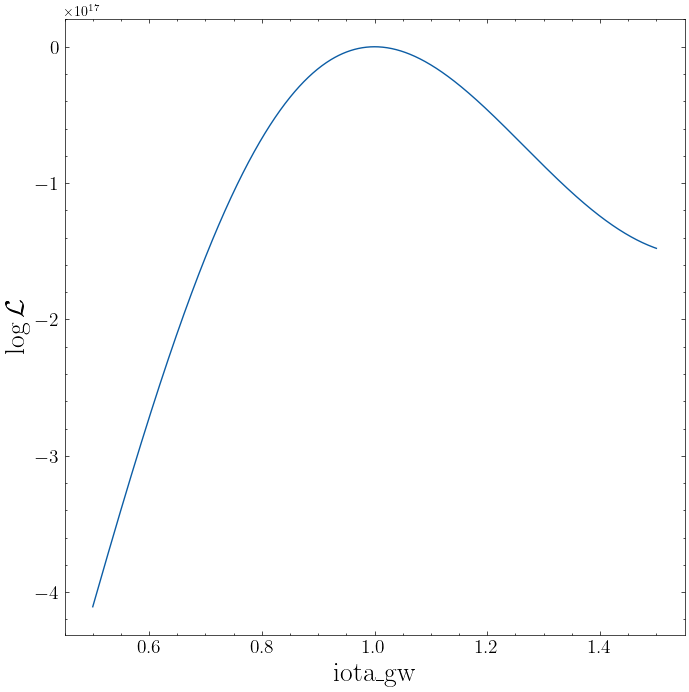

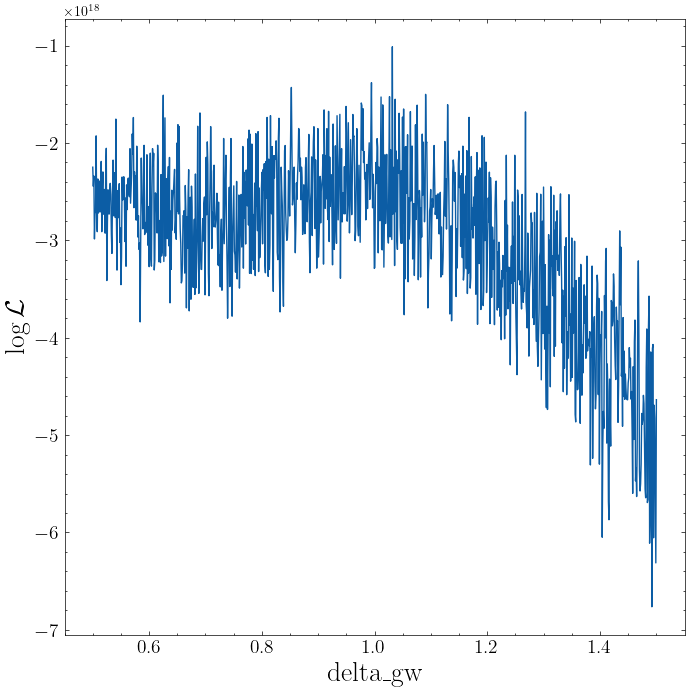

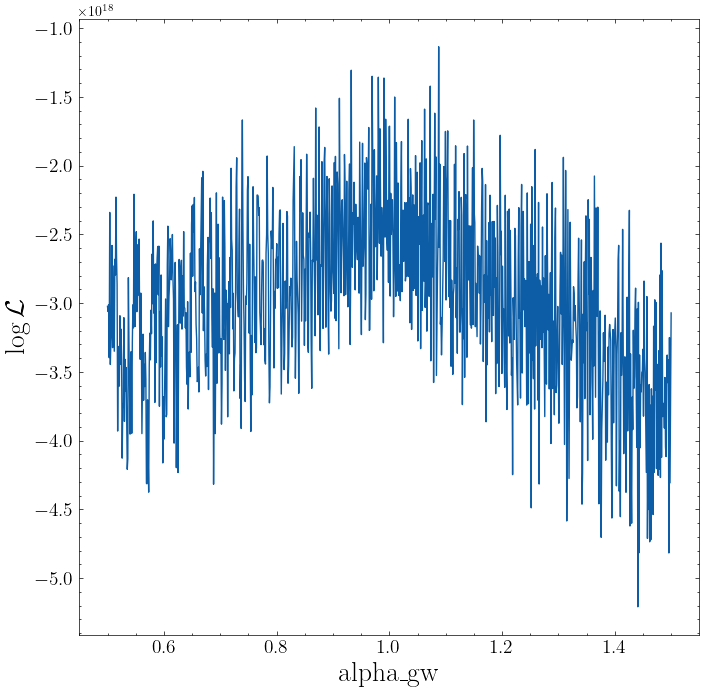

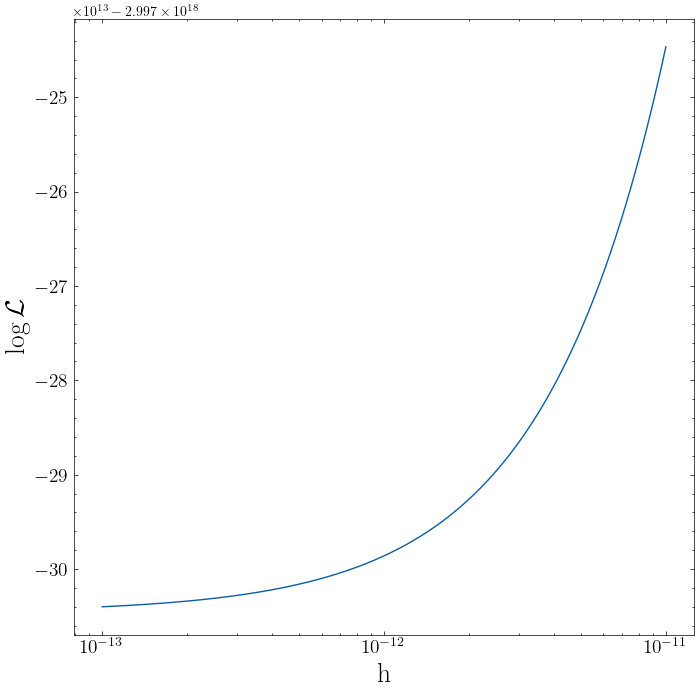

In [8]:
#And plot it all
log_axes = ["omega_gw","h"]
for j,parameter_name in enumerate(parameter_names):
    if parameter_name in log_axes:
        log_x_axes=True
    else:
        log_x_axes=False
    plot_likelihood(parameter_ranges[j],likelihood_data_dictionary[parameter_name],parameter_name,log_x_axes=log_x_axes)


Most of the curves reamain smooth, but $\Omega$, $\delta$ and and $\alpha$ are super noisy


### What about with just the Earth terms?


Lets do the same again, but drop the pulsar terms

In [9]:
#Set the measurement model again
measurement_model = 'earth' #Set the measurement model 


parameter_names = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw", "h"]
N = int(1e3)
parameter_ranges = [np.logspace(-9,-5,N),
                    np.linspace(-1.0,1.0,N),
                    np.linspace(2.0,3.0,N),
                    np.linspace(0.5,1.5,N),
                    np.linspace(0.5,1.5,N),
                    np.linspace(0.5,1.5,N),
                    np.logspace(-13,-11,N)
]



likelihood_data_dictionary_earth={}


for j,parameter_name in enumerate(parameter_names):
    parameter_range = parameter_ranges[j]
    likelihood_data_array = np.zeros(len(parameter_range))     
      

    for i,p in enumerate(parameter_range):
        p = parameter_range[i]
        likelihood_data_array[i] = get_likelihood(data,parameter_name,p,P,PTA,measurement_model)

    likelihood_data_dictionary_earth[parameter_name] = likelihood_data_array

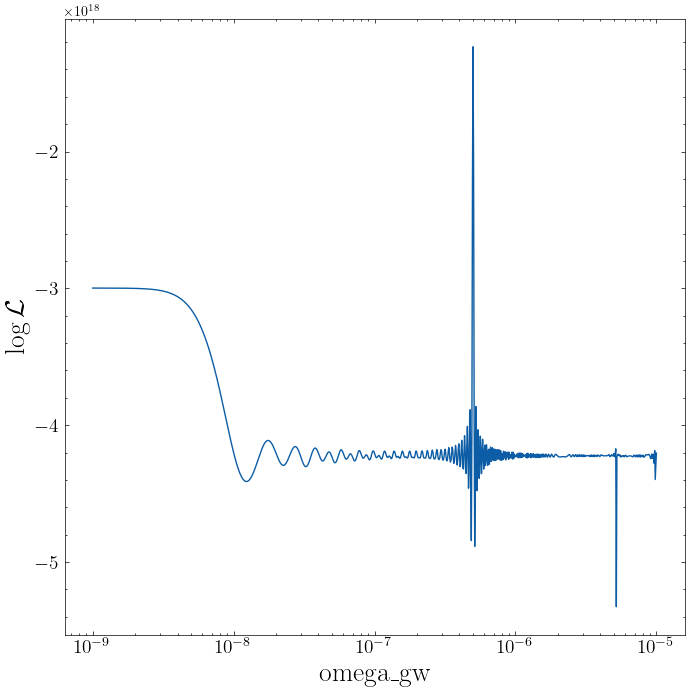

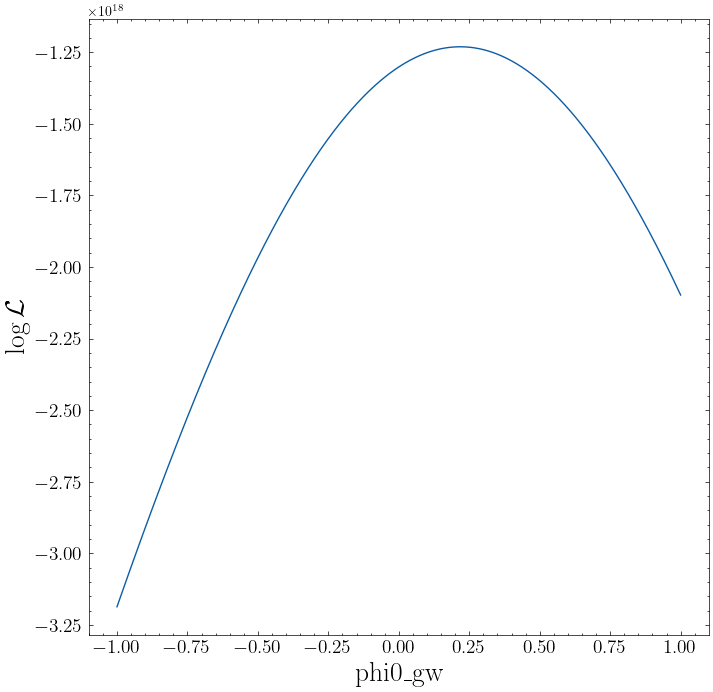

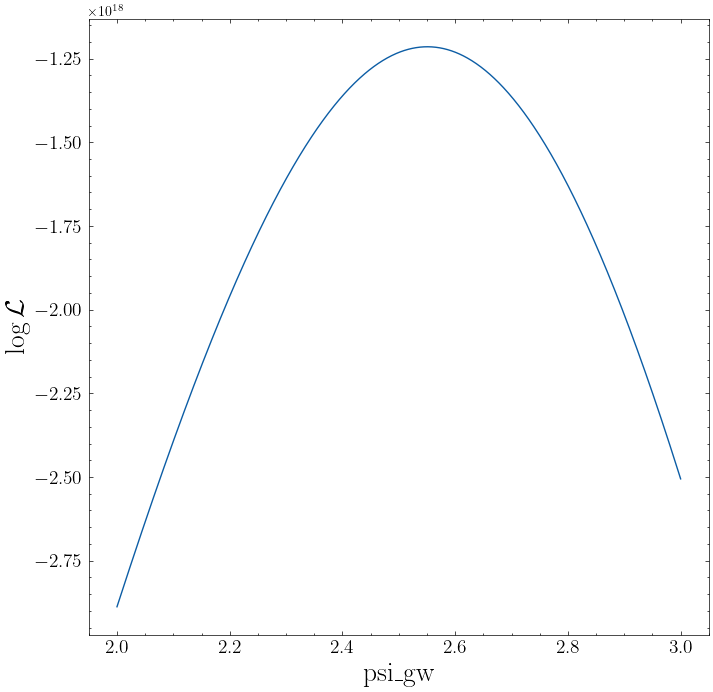

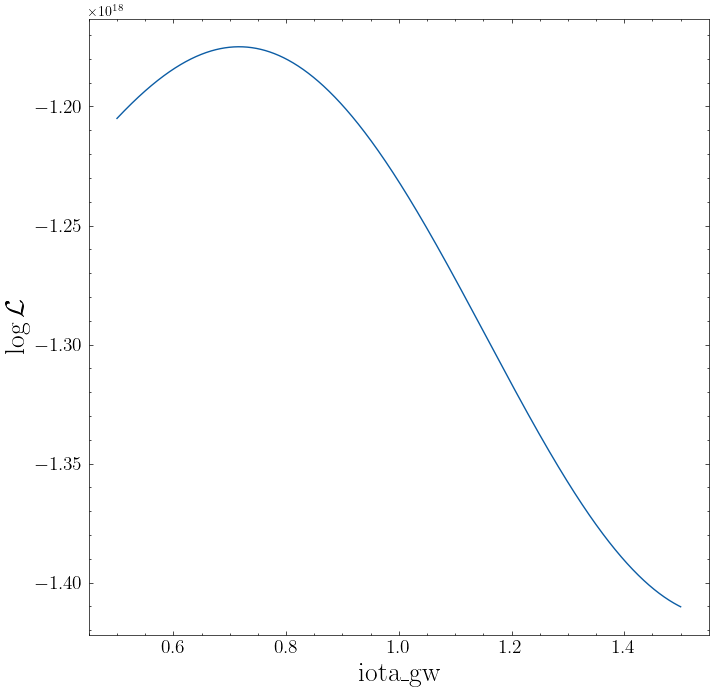

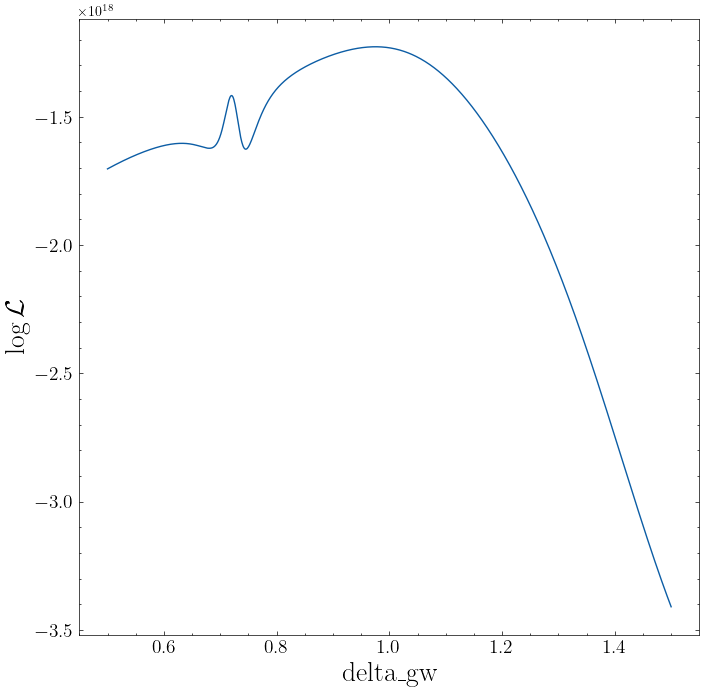

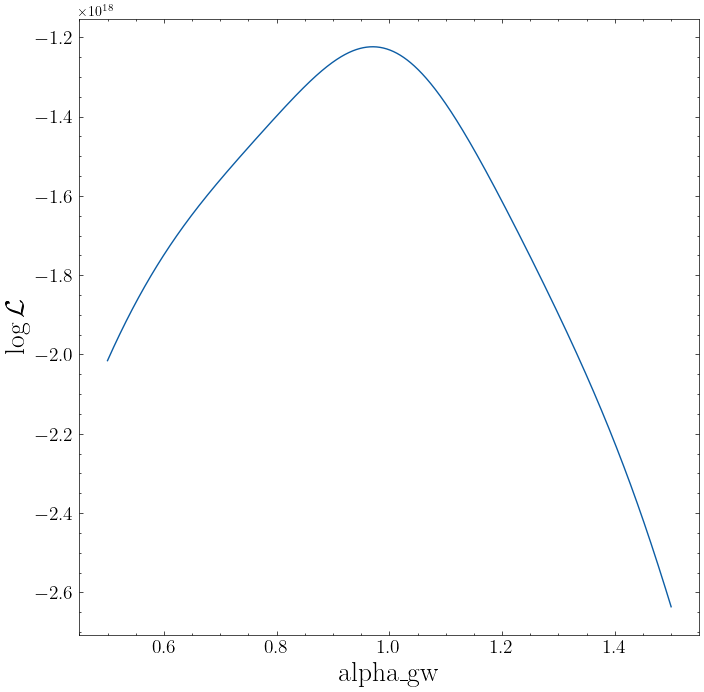

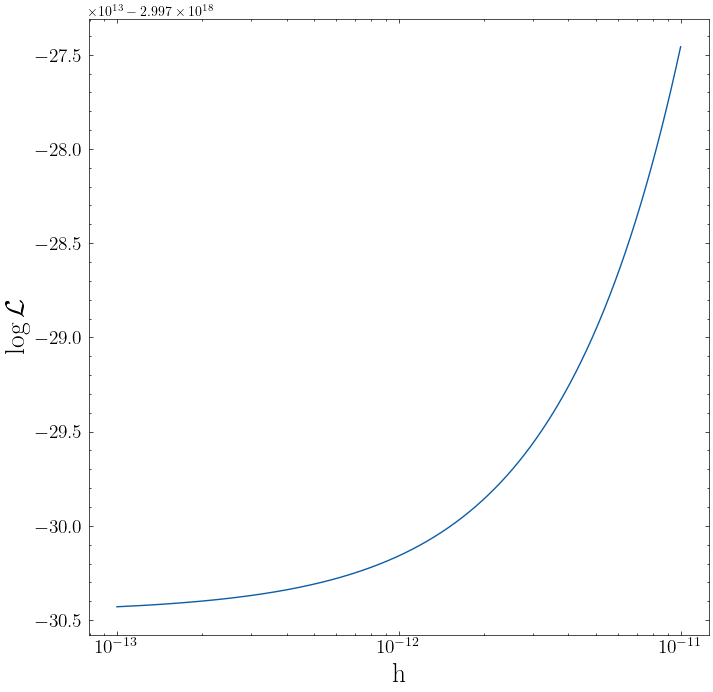

In [10]:
#And plot it all
log_axes = ["omega_gw","h"]
for j,parameter_name in enumerate(parameter_names):
    if parameter_name in log_axes:
        log_x_axes=True
    else:
        log_x_axes=False
    plot_likelihood(parameter_ranges[j],likelihood_data_dictionary_earth[parameter_name],parameter_name,log_x_axes=log_x_axes)
